In [2]:
import pandas as pd
import os
import seaborn as sns
import random
import matplotlib.pyplot as plt
import numpy as np

os.getcwd()

'/home/yannikkellerde/github_repos/algorithmic-institutions/notebooks/test_manager'

In [3]:
%matplotlib inline

In [4]:
fig_path = "../../plots/05_all"
os.makedirs(fig_path, exist_ok=True)

In [5]:
df1 = pd.read_csv("../../evals/05_all/data.csv")
df2 = pd.read_csv("../../evals/07_all/data.csv")
df2 = df2[
    df2["run"].isin(
        [
            "ah full managed by group_payoff_maximize",
        ]
    )
]
df = pd.concat([df1, df2])

/tmp/ipykernel_107817/3610073140.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv("../../evals/05_all/data.csv")
/tmp/ipykernel_107817/3610073140.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv("../../evals/07_all/data.csv")


In [6]:
df = df[~df["run"].str.contains("ah human")]

In [7]:
df["run"].unique()

array(['ah full managed by humanlike', 'ah full managed by gamma_1',
       'ah full managed by gamma_08', 'ah full managed by gamma_09',
       'ah full managed by gamma_05', 'ah full managed by gamma_0',
       'pilot human manager', 'pilot rule based manager',
       'ah full managed by group_payoff_maximize'], dtype=object)

In [8]:
df["payoff"] = 20 - df["contribution"] - df["punishment"] + df["common_good"]

In [9]:
df["common_good"].max()

32.0

In [10]:
def clean_run_name(run_name):
    return run_name.replace("ah full managed by ", "").replace(
        "ah human managed managed by ", ""
    )


df["run"] = df["run"].apply(clean_run_name)

dfm = df.melt(
    id_vars=["episode", "round_number", "participant_code", "run"],
    value_vars=["punishment", "contribution", "common_good", "payoff"],
)

In [11]:
df

,episode,participant_code,round_number,punishment,common_good,contribution,group,run,global_group_id,payoff
96000,ah full managed by humanlike__0,0_0,0,0.0,15.600000,6.0,0.0,humanlike,NaN,29.600000
96001,ah full managed by humanlike__0,0_0,1,0.0,14.800000,7.0,0.0,humanlike,NaN,27.800000
96002,ah full managed by humanlike__0,0_0,2,0.0,12.400001,5.0,0.0,humanlike,NaN,27.400001
96003,ah full managed by humanlike__0,0_0,3,0.0,10.800000,2.0,0.0,humanlike,NaN,28.800000
96004,ah full managed by humanlike__0,0_0,4,0.0,10.133333,7.0,0.0,humanlike,NaN,23.133333
...,...,...,...,...,...,...,...,...,...,...
191995,ah full managed by group_payoff_maximize__999,3_999,19,0.0,28.400000,16.0,0.0,group_payoff_maximize,NaN,32.400000
191996,ah full managed by group_payoff_maximize__999,3_999,20,0.0,27.200001,13.0,0.0,group_payoff_maximize,NaN,34.200001
191997,ah full managed by group_payoff_maximize__999,3_999,21,0.0,28.400000,13.0,0.0,group_payoff_maximize,NaN,35.400000
191998,ah full managed by group_payoff_maximize__999,3_999,22,0.0,30.000000,17.0,0.0,group_payoff_maximize,NaN,33.000000


In [12]:
dfst = (
    df[["run", "episode", "contribution", "round_number", "punishment"]]
    .groupby(["run", "episode", "contribution", "round_number"])
    .agg(["std", "count"])
    .reset_index()
)

In [13]:
dfst.columns = dfst.columns.to_flat_index().str.join("")
dfst = dfst.rename(
    columns={"punishmentstd": "punishment_std", "punishmentcount": "punishment_count"}
)
dfst = dfst[dfst["punishment_count"] > 1]

In [14]:
dfst.punishment_std.mean()

0.28204809607333753

In [15]:
# dfr = df[df["run"].isin(["gamma_1","gamma_09","gamma_08","gamma_05","gamma_0"])]
dfr = df.copy()

In [16]:
dfr["contrib_rank"] = (
    dfr[["run", "episode", "contribution", "round_number", "punishment"]]
    .groupby(["run", "episode", "round_number"])["contribution"]
    .rank(method="dense", ascending=False)
)
dfr["punish_with_tiebreaker"] = dfr["punishment"] + dfr["contrib_rank"] * 0.01

dfr["punish_rank"] = (
    dfr[["run", "episode", "contribution", "round_number", "punish_with_tiebreaker"]]
    .groupby(["run", "episode", "round_number"])["punish_with_tiebreaker"]
    .rank(method="dense")
)

In [17]:
# Round level fairness measure
choose_runs = ["pilot human manager"]

(
    dfr[dfr["run"].isin(choose_runs)]["punish_rank"]
    == dfr[dfr["run"].isin(choose_runs)]["contrib_rank"]
).mean()

0.725258493353028

In [18]:
# Round level fairness measure
choose_runs = ["gamma_09"]

(
    dfr[dfr["run"].isin(choose_runs)]["punish_rank"]
    == dfr[dfr["run"].isin(choose_runs)]["contrib_rank"]
).mean()

0.8841770833333333

In [19]:
dfr[dfr["round_number"] == 1]

,episode,participant_code,round_number,punishment,common_good,contribution,group,run,global_group_id,payoff,contrib_rank,punish_with_tiebreaker,punish_rank
96001,ah full managed by humanlike__0,0_0,1,0.0,14.8,7.0,0.0,humanlike,NaN,27.8,3.0,0.03,3.0
96025,ah full managed by humanlike__0,1_0,1,0.0,14.8,10.0,0.0,humanlike,NaN,24.8,2.0,0.02,2.0
96049,ah full managed by humanlike__0,2_0,1,0.0,14.8,6.0,0.0,humanlike,NaN,28.8,4.0,0.04,4.0
96073,ah full managed by humanlike__0,3_0,1,0.0,14.8,14.0,0.0,humanlike,NaN,20.8,1.0,0.01,1.0
96097,ah full managed by humanlike__1,0_1,1,0.0,28.0,10.0,0.0,humanlike,NaN,38.0,2.0,0.02,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
191881,ah full managed by group_payoff_maximize__998,3_998,1,3.0,8.2,10.0,0.0,group_payoff_maximize,NaN,15.2,2.0,3.02,2.0
191905,ah full managed by group_payoff_maximize__999,0_999,1,3.0,9.0,14.0,0.0,group_payoff_maximize,NaN,12.0,1.0,3.01,1.0
191929,ah full managed by group_payoff_maximize__999,1_999,1,3.0,9.0,12.0,0.0,group_payoff_maximize,NaN,14.0,2.0,3.02,2.0
191953,ah full managed by group_payoff_maximize__999,2_999,1,7.0,9.0,10.0,0.0,group_payoff_maximize,NaN,12.0,3.0,7.03,3.0


In [20]:
dfm

,episode,round_number,participant_code,run,variable,value
0,ah full managed by humanlike__0,0,0_0,humanlike,punishment,0.000000
1,ah full managed by humanlike__0,1,0_0,humanlike,punishment,0.000000
2,ah full managed by humanlike__0,2,0_0,humanlike,punishment,0.000000
3,ah full managed by humanlike__0,3,0_0,humanlike,punishment,0.000000
4,ah full managed by humanlike__0,4,0_0,humanlike,punishment,0.000000
...,...,...,...,...,...,...
2711371,ah full managed by group_payoff_maximize__999,19,3_999,group_payoff_maximize,payoff,32.400000
2711372,ah full managed by group_payoff_maximize__999,20,3_999,group_payoff_maximize,payoff,34.200001
2711373,ah full managed by group_payoff_maximize__999,21,3_999,group_payoff_maximize,payoff,35.400000
2711374,ah full managed by group_payoff_maximize__999,22,3_999,group_payoff_maximize,payoff,33.000000


In [21]:
dfe = (
    dfm[
        ~dfm["run"].isin(
            ["pilot human manager", "pilot rule based manager", "humanlike"]
        )
    ][dfm["variable"].isin(("payoff", "contribution", "punishment"))][
        ["episode", "participant_code", "value", "run", "variable"]
    ]
    .groupby(["episode", "participant_code", "run", "variable"])
    .sum()
    .reset_index()
)
dfe

/tmp/ipykernel_107817/3235964637.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfm[


,episode,participant_code,run,variable,value
0,ah full managed by gamma_05__0,0_0,gamma_05,contribution,420.000000
1,ah full managed by gamma_05__0,0_0,gamma_05,payoff,746.200006
2,ah full managed by gamma_05__0,0_0,gamma_05,punishment,9.000000
3,ah full managed by gamma_05__0,1_0,gamma_05,contribution,392.000000
4,ah full managed by gamma_05__0,1_0,gamma_05,payoff,771.200006
...,...,...,...,...,...
71995,ah full managed by group_payoff_maximize__999,2_999,group_payoff_maximize,payoff,615.800004
71996,ah full managed by group_payoff_maximize__999,2_999,group_payoff_maximize,punishment,23.000000
71997,ah full managed by group_payoff_maximize__999,3_999,group_payoff_maximize,contribution,354.000000
71998,ah full managed by group_payoff_maximize__999,3_999,group_payoff_maximize,payoff,688.800004


In [22]:
df_big = (
    dfe[dfe["variable"] == "contribution"]
    .merge(dfe[dfe["variable"] == "payoff"], on=["episode", "participant_code", "run"])
    .merge(
        dfe[dfe["variable"] == "punishment"], on=["episode", "participant_code", "run"]
    )
    .rename(
        columns={"value_x": "contribution", "value_y": "payoff", "value": "punishment"}
    )
    .drop(columns=["variable_x", "variable_y", "variable"])
)

In [23]:
df_big

,episode,participant_code,run,contribution,payoff,punishment
0,ah full managed by gamma_05__0,0_0,gamma_05,420.0,746.200006,9.0
1,ah full managed by gamma_05__0,1_0,gamma_05,392.0,771.200006,12.0
2,ah full managed by gamma_05__0,2_0,gamma_05,470.0,699.200006,6.0
3,ah full managed by gamma_05__0,3_0,gamma_05,470.0,700.200006,5.0
4,ah full managed by gamma_05__1,0_1,gamma_05,469.0,698.666679,3.0
...,...,...,...,...,...,...
23995,ah full managed by group_payoff_maximize__998,3_998,group_payoff_maximize,451.0,613.550007,36.0
23996,ah full managed by group_payoff_maximize__999,0_999,group_payoff_maximize,422.0,644.800004,19.0
23997,ah full managed by group_payoff_maximize__999,1_999,group_payoff_maximize,364.0,690.800004,31.0
23998,ah full managed by group_payoff_maximize__999,2_999,group_payoff_maximize,447.0,615.800004,23.0


In [24]:
mean_df = df_big.groupby("episode").mean(numeric_only=True).reset_index()

In [25]:
dfg = df_big.join(mean_df.set_index("episode"), on="episode", rsuffix="_mean")
dfg["contribution_delta"] = dfg["contribution"] - dfg["contribution_mean"]
dfg["payoff_delta"] = dfg["payoff"] - dfg["payoff_mean"]
dfg["punishment_delta"] = dfg["punishment"] - dfg["punishment_mean"]
dfg

,episode,participant_code,run,contribution,payoff,punishment,contribution_mean,payoff_mean,punishment_mean,contribution_delta,payoff_delta,punishment_delta
0,ah full managed by gamma_05__0,0_0,gamma_05,420.0,746.200006,9.0,438.00,729.200006,8.00,-18.00,17.00,1.00
1,ah full managed by gamma_05__0,1_0,gamma_05,392.0,771.200006,12.0,438.00,729.200006,8.00,-46.00,42.00,4.00
2,ah full managed by gamma_05__0,2_0,gamma_05,470.0,699.200006,6.0,438.00,729.200006,8.00,32.00,-30.00,-2.00
3,ah full managed by gamma_05__0,3_0,gamma_05,470.0,700.200006,5.0,438.00,729.200006,8.00,32.00,-29.00,-3.00
4,ah full managed by gamma_05__1,0_1,gamma_05,469.0,698.666679,3.0,431.00,737.666679,2.00,38.00,-39.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...
23995,ah full managed by group_payoff_maximize__998,3_998,group_payoff_maximize,451.0,613.550007,36.0,408.00,660.300007,32.25,43.00,-46.75,3.75
23996,ah full managed by group_payoff_maximize__999,0_999,group_payoff_maximize,422.0,644.800004,19.0,396.75,660.050004,29.00,25.25,-15.25,-10.00
23997,ah full managed by group_payoff_maximize__999,1_999,group_payoff_maximize,364.0,690.800004,31.0,396.75,660.050004,29.00,-32.75,30.75,2.00
23998,ah full managed by group_payoff_maximize__999,2_999,group_payoff_maximize,447.0,615.800004,23.0,396.75,660.050004,29.00,50.25,-44.25,-6.00


In [26]:
dft = dfg[dfg["run"] == "gamma_1"]
dftt = dft[dft["contribution_delta"] < 40]
dftt = dftt[dftt["contribution_delta"] > -40]
len(dftt) / len(dft)

0.86125

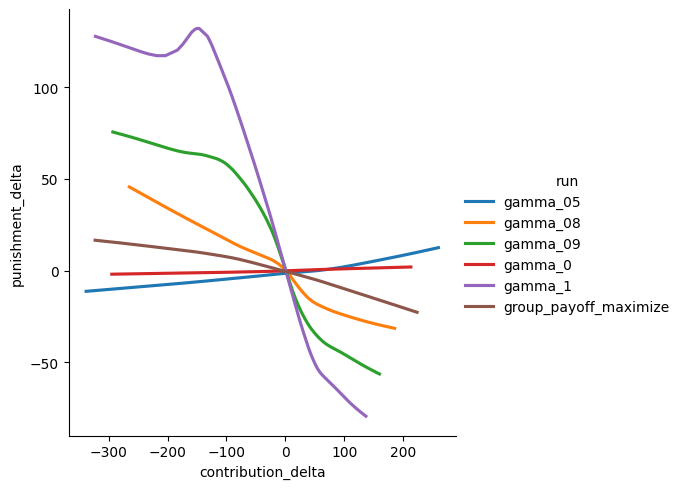

In [27]:
g = sns.lmplot(
    data=dfg,
    x="contribution_delta",
    y="punishment_delta",
    hue="run",
    scatter=False,
    lowess=True,
)
g.savefig(os.path.join(fig_path, "contrib_punishment_delta_lowess.png"))

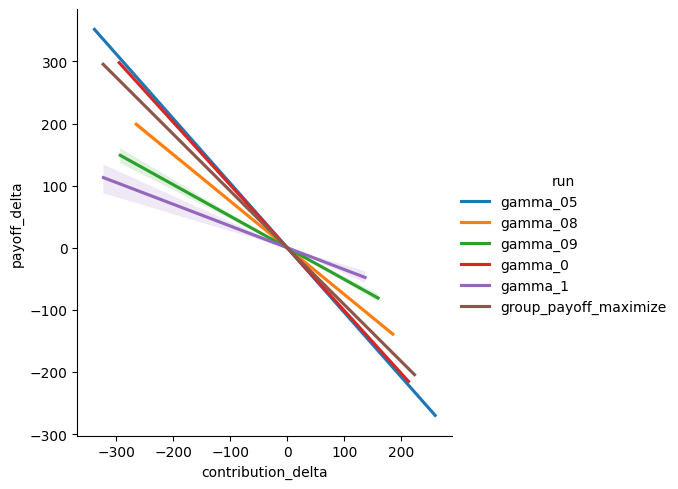

In [28]:
g = sns.lmplot(
    data=dfg,
    x="contribution_delta",
    y="payoff_delta",
    hue="run",
    scatter=False,
    lowess=False,
)

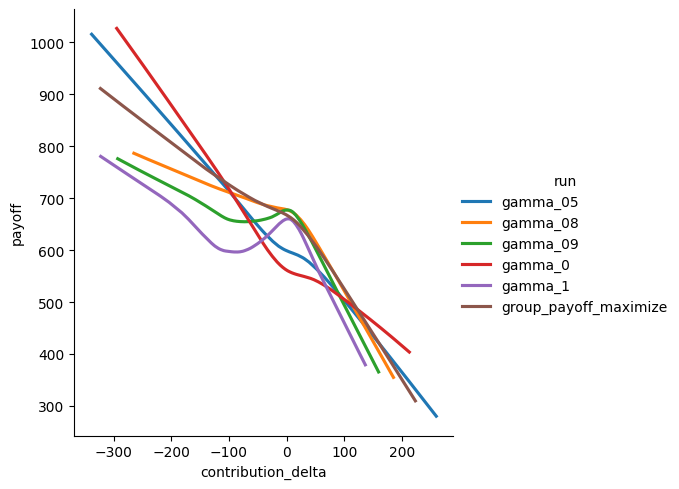

In [29]:
g = sns.lmplot(
    data=dfg,
    x="contribution_delta",
    y="payoff",
    hue="run",
    scatter=False,
    lowess=True,
)
g.savefig(os.path.join(fig_path, "contrib_delta_payoff_lowess.png"))

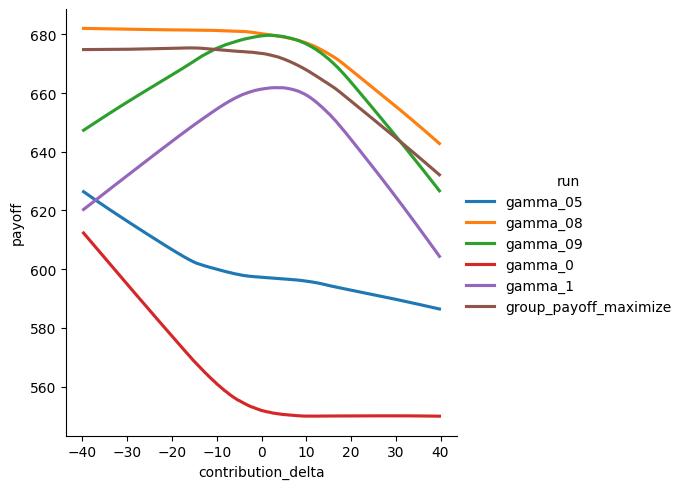

In [30]:
test_df = dfg[dfg["contribution_delta"] > -40]
test_df = test_df[test_df["contribution_delta"] < 40]
g = sns.lmplot(
    data=test_df,
    x="contribution_delta",
    y="payoff",
    hue="run",
    scatter=False,
    lowess=True,
)
g.savefig(os.path.join(fig_path, "contrib_delta_payoff_40.png"))

In [31]:
def obtain_dfs(dfm: pd.DataFrame, max_round_number):
    dfm1 = dfm[dfm["round_number"] < max_round_number]
    dfe1 = (
        dfm1[
            ~dfm1["run"].isin(
                ["pilot human manager", "pilot rule based manager", "humanlike"]
            )
        ][dfm1["variable"].isin(("payoff", "contribution", "punishment"))][
            ["episode", "participant_code", "value", "run", "variable"]
        ]
        .groupby(["episode", "participant_code", "run", "variable"])
        .sum()
        .reset_index()
    )
    df_big1 = (
        dfe1[dfe1["variable"] == "contribution"]
        .merge(
            dfe1[dfe1["variable"] == "payoff"],
            on=["episode", "participant_code", "run"],
        )
        .merge(
            dfe1[dfe1["variable"] == "punishment"],
            on=["episode", "participant_code", "run"],
        )
        .rename(
            columns={
                "value_x": "contribution",
                "value_y": "payoff",
                "value": "punishment",
            }
        )
        .drop(columns=["variable_x", "variable_y", "variable"])
    )
    mean_df1 = df_big1.groupby("episode").mean(numeric_only=True).reset_index()
    dfg1 = df_big1.join(mean_df1.set_index("episode"), on="episode", rsuffix="_mean")
    dfg1["contribution_delta"] = dfg1["contribution"] - dfg1["contribution_mean"]
    dfg1["payoff_delta"] = dfg1["payoff"] - dfg1["payoff_mean"]
    dfg1["punishment_delta"] = dfg1["punishment"] - dfg1["punishment_mean"]

    return dfg1, mean_df1, df_big1, dfe1, dfm1

/tmp/ipykernel_107817/4073298471.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfm1[
/tmp/ipykernel_107817/4073298471.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfm1[
/tmp/ipykernel_107817/4073298471.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfm1[
/tmp/ipykernel_107817/4073298471.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfm1[
/tmp/ipykernel_107817/4073298471.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfm1[
/tmp/ipykernel_107817/4073298471.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfm1[


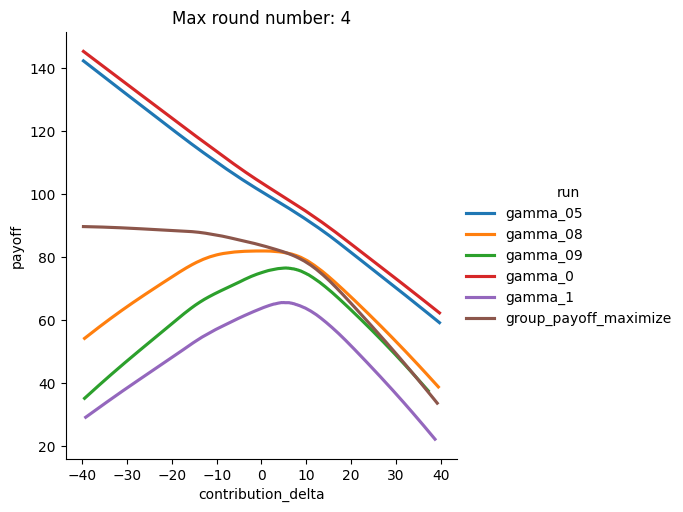

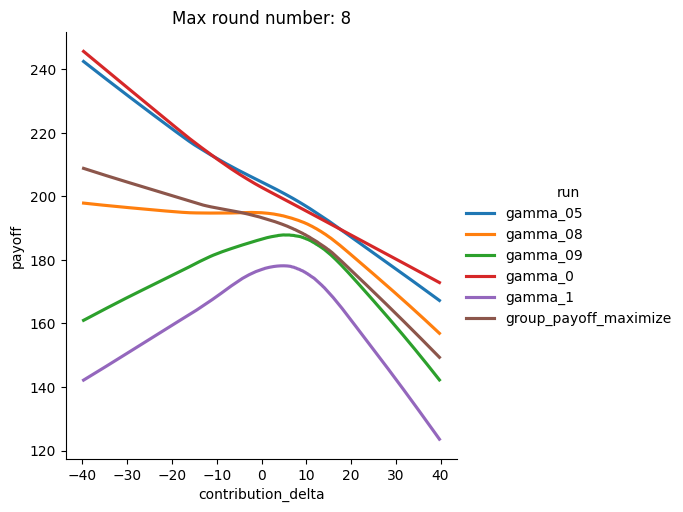

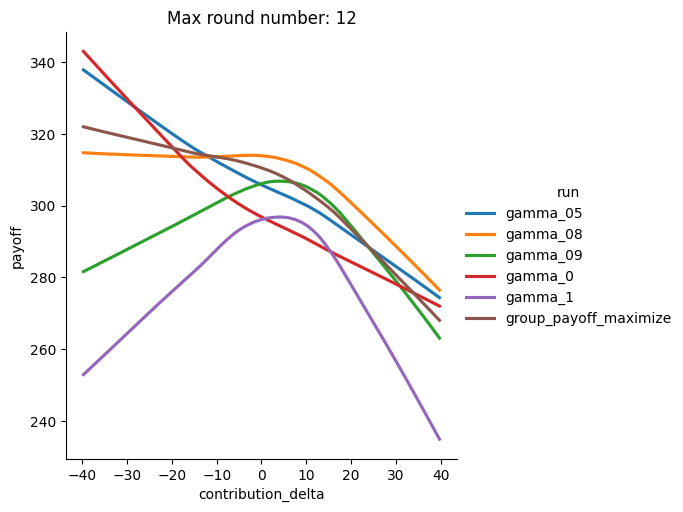

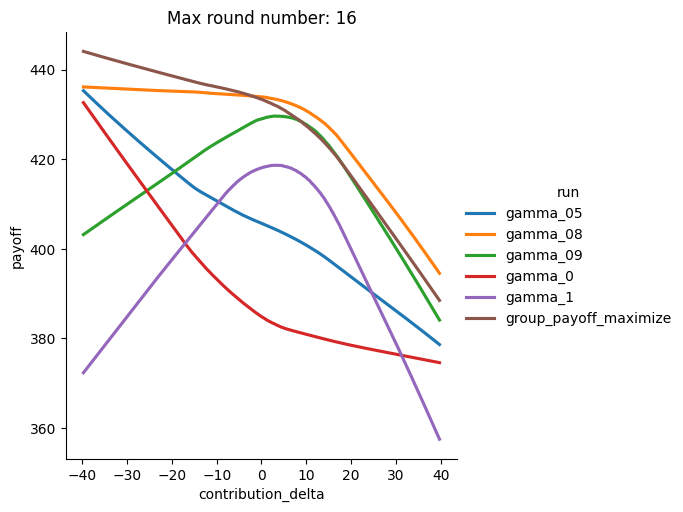

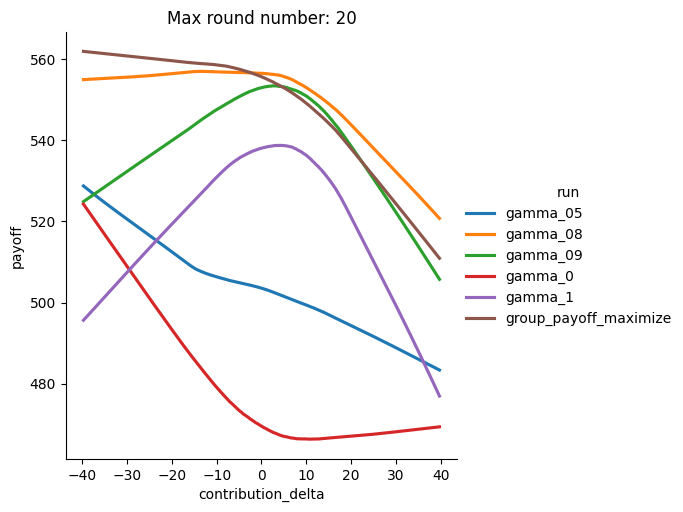

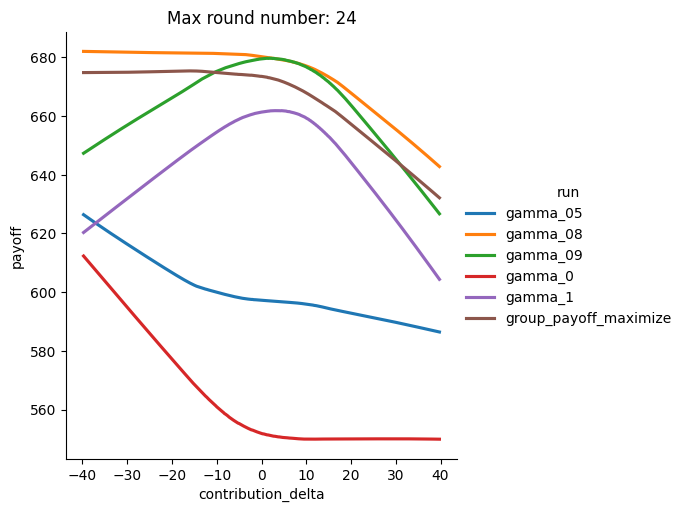

In [32]:
for i in range(4, 25, 4):
    dfg1 = obtain_dfs(dfm, i)[0]
    tdf = dfg1[dfg1["contribution_delta"] > -40]
    tdf = tdf[tdf["contribution_delta"] < 40]
    g = sns.lmplot(
        data=tdf,
        x="contribution_delta",
        y="payoff",
        hue="run",
        scatter=False,
        lowess=True,
    )
    ax = plt.gca()
    ax.set_title(f"Max round number: {i}")
    g.savefig(os.path.join(fig_path, f"contrib_delta_payoff_40_max_round_{i}.png"))

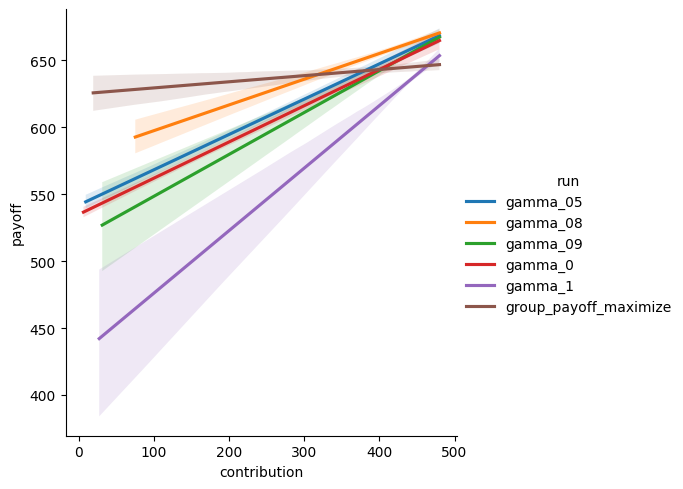

In [33]:
g = sns.lmplot(
    data=df_big, x="contribution", y="payoff", hue="run", scatter=False, lowess=False
)
g.savefig(os.path.join(fig_path, "contrib_payoff_linreg.png"))

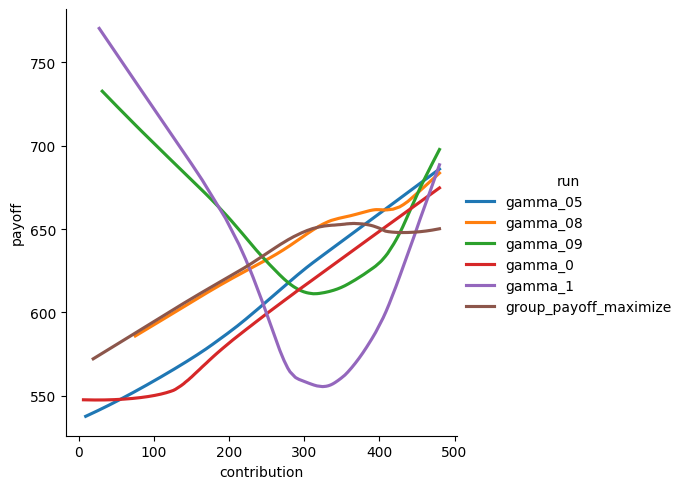

In [34]:
g = sns.lmplot(
    data=df_big, x="contribution", y="payoff", hue="run", scatter=False, lowess=True
)
g.savefig(os.path.join(fig_path, "contrib_payoff_lowess.jpg"))


# Set y-axis limits to start at 0 for all plots
# g.set(ylim=(0, None))

# g.savefig(os.path.join(fig_path, "contrib_payoff.jpg"))

In [35]:
summed_payoffs = (
    dfm[dfm["variable"] == "payoff"]
    .groupby(["episode", "participant_code", "run"])
    .sum()
)

/tmp/ipykernel_107817/65951394.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfm[dfm["variable"] == "payoff"]


In [36]:
summed_payoffs

round_number  \
episode                               participant_code run                                      
ah full managed by gamma_05__0        0_0              gamma_05                           276   
                                      1_0              gamma_05                           276   
                                      2_0              gamma_05                           276   
                                      3_0              gamma_05                           276   
ah full managed by gamma_05__1        0_1              gamma_05                           276   
...                                                                                       ...   
pilot rule based manager__yaxdn9bp #8 max90slk         pilot rule based manager           120   
pilot rule based manager__yaxdn9bp #9 ed6y65hl         pilot rule based manager           120   
                                      ejsmzc3l         pilot rule based manager           120   
                                      ggxfecfc         pilot rule based manager           120   
                                      t5rvjb1y         pilot rule based manager           120   

                                                                                      value  
episode                               participant_code run                                   
ah full managed by gamma_05__0        0_0              gamma_05                  746.200006  
                                      1_0              gamma_05                  771.200006  
                                      2_0              gamma_05                  699.200006  
                                      3_0              gamma_05                  700.200006  
ah full managed by gamma_05__1        0_1              gamma_05                  698.666679  
...                                                                                     ...  
pilot rule based manager__yaxdn9bp #8 max90slk         pilot rule based manager  259.500000  
pilot rule based manager__yaxdn9bp #9 ed6y65hl         pilot rule based manager  237.500000  
                                      ejsmzc3l         pilot rule based manager  168.500000  
                                      ggxfecfc         pilot rule based manager  245.500000  
                                      t5rvjb1y         pilot rule based manager  253.500000  

[28411 rows x 2 columns]

In [55]:
sp = summed_payoffs.reset_index()

In [56]:
sp

,episode,participant_code,run,round_number,value
0,ah full managed by gamma_05__0,0_0,gamma_05,276,746.200006
1,ah full managed by gamma_05__0,1_0,gamma_05,276,771.200006
2,ah full managed by gamma_05__0,2_0,gamma_05,276,699.200006
3,ah full managed by gamma_05__0,3_0,gamma_05,276,700.200006
4,ah full managed by gamma_05__1,0_1,gamma_05,276,698.666679
...,...,...,...,...,...
28406,pilot rule based manager__yaxdn9bp #8,max90slk,pilot rule based manager,120,259.500000
28407,pilot rule based manager__yaxdn9bp #9,ed6y65hl,pilot rule based manager,120,237.500000
28408,pilot rule based manager__yaxdn9bp #9,ejsmzc3l,pilot rule based manager,120,168.500000
28409,pilot rule based manager__yaxdn9bp #9,ggxfecfc,pilot rule based manager,120,245.500000


In [57]:
sp = sp[["run", "value"]].groupby("run").mean()

In [58]:
sp = sp.reset_index()

In [59]:
sp

,run,value
0,gamma_0,587.096455
1,gamma_05,605.454155
2,gamma_08,655.857657
3,gamma_09,651.490739
4,gamma_1,634.076437
5,group_payoff_maximize,641.327257
6,humanlike,550.547156
7,pilot human manager,282.902326
8,pilot rule based manager,343.086735


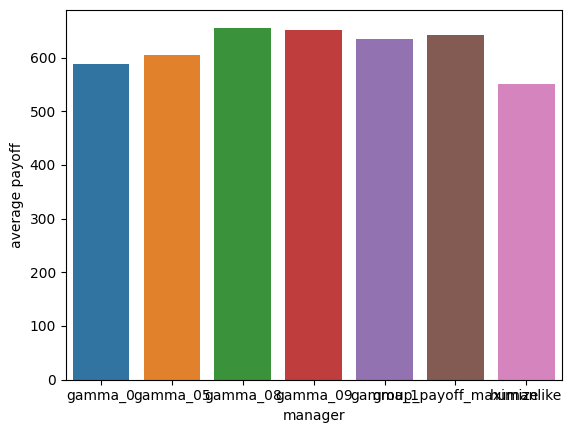

In [60]:
sp = sp[
    sp["run"].isin(
        [
            "gamma_05",
            "gamma_0",
            "gamma_08",
            "gamma_09",
            "gamma_1",
            "humanlike",
            "group_payoff_maximize",
        ]
    )
]

g = sns.barplot(data=sp, x="run", y="value")
plt.xticks(rotation=45)
g.set(ylabel="average payoff", xlabel="manager")
g.figure.savefig(os.path.join(fig_path, "payoff.png"))

In [43]:
dfm["run"].unique()

array(['humanlike', 'gamma_1', 'gamma_08', 'gamma_09', 'gamma_05',
       'gamma_0', 'pilot human manager', 'pilot rule based manager',
       'group_payoff_maximize'], dtype=object)

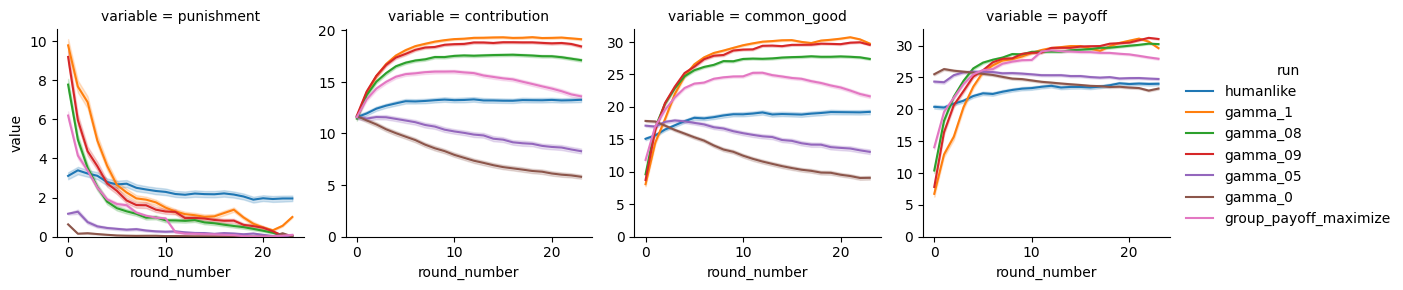

In [44]:
w = ~dfm["run"].isin(
    [
        "pilot human manager",
        "pilot rule based manager",
    ]
)

dfg = dfm[w].copy()

g = sns.relplot(
    data=dfg,
    x="round_number",
    y="value",
    col="variable",
    hue="run",
    kind="line",
    facet_kws={"sharey": False, "sharex": True},
    height=3,
    aspect=1,
)


# Set y-axis limits to start at 0 for all plots
g.set(ylim=(0, None))

g.savefig(os.path.join(fig_path, "comparison_manager.jpg"))

In [45]:
dfsum = dfm[["run", "round_number", "variable", "value"]]

In [46]:
dfsum = dfsum[dfsum["variable"] == "payoff"]

In [47]:
mean_df = (
    dfsum[["run", "round_number", "value"]]
    .groupby(["run", "round_number"])
    .mean()
    .reset_index()
)

In [48]:
mean_df[mean_df["round_number"] == 2]

,run,round_number,value
2,gamma_0,2,26.052350
26,gamma_05,2,25.345717
50,gamma_08,2,21.955900
74,gamma_09,2,20.626784
98,gamma_1,2,15.662000
122,group_payoff_maximize,2,21.810834
146,humanlike,2,20.865284
170,pilot human manager,2,22.505814
178,pilot rule based manager,2,18.142857


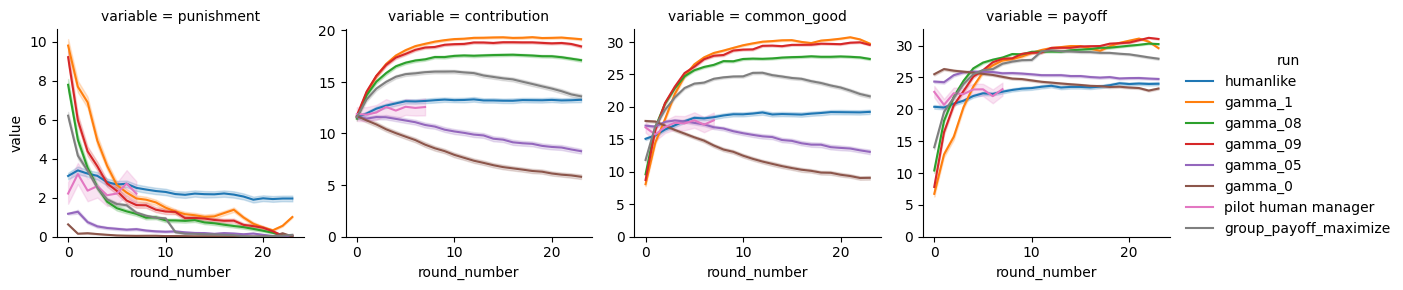

In [49]:
w = ~dfm["run"].isin(
    [
        "pilot rule based manager",
    ]
)

dfg = dfm[w].copy()

g = sns.relplot(
    data=dfg,
    x="round_number",
    y="value",
    col="variable",
    hue="run",
    kind="line",
    facet_kws={"sharey": False, "sharex": True},
    height=3,
    aspect=1,
)

# Set y-axis limits to start at 0 for all plots
g.set(ylim=(0, None))

g.savefig(os.path.join(fig_path, "comparison_pilot.jpg"))

In [50]:
dfg

,episode,round_number,participant_code,run,variable,value
0,ah full managed by humanlike__0,0,0_0,humanlike,punishment,0.000000
1,ah full managed by humanlike__0,1,0_0,humanlike,punishment,0.000000
2,ah full managed by humanlike__0,2,0_0,humanlike,punishment,0.000000
3,ah full managed by humanlike__0,3,0_0,humanlike,punishment,0.000000
4,ah full managed by humanlike__0,4,0_0,humanlike,punishment,0.000000
...,...,...,...,...,...,...
2711371,ah full managed by group_payoff_maximize__999,19,3_999,group_payoff_maximize,payoff,32.400000
2711372,ah full managed by group_payoff_maximize__999,20,3_999,group_payoff_maximize,payoff,34.200001
2711373,ah full managed by group_payoff_maximize__999,21,3_999,group_payoff_maximize,payoff,35.400000
2711374,ah full managed by group_payoff_maximize__999,22,3_999,group_payoff_maximize,payoff,33.000000


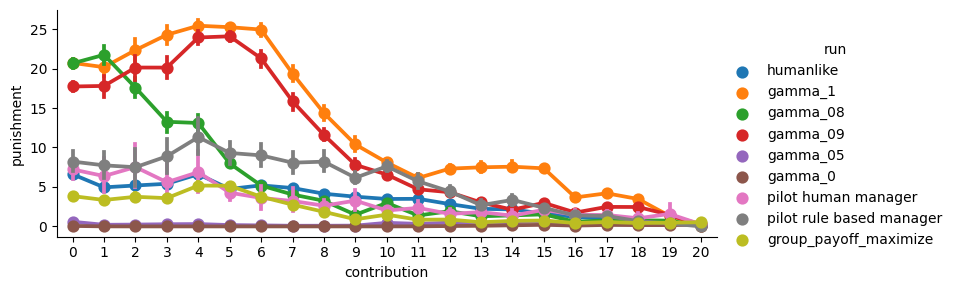

In [51]:
df["contribution"] = df["contribution"].astype(int)


dfs = df.copy()


g = sns.catplot(
    data=dfs,
    x="contribution",
    y="punishment",
    hue="run",
    kind="point",
    height=3,
    aspect=2.5,
)

g.savefig(os.path.join(fig_path, "comparison_pilot_policy.jpg"))

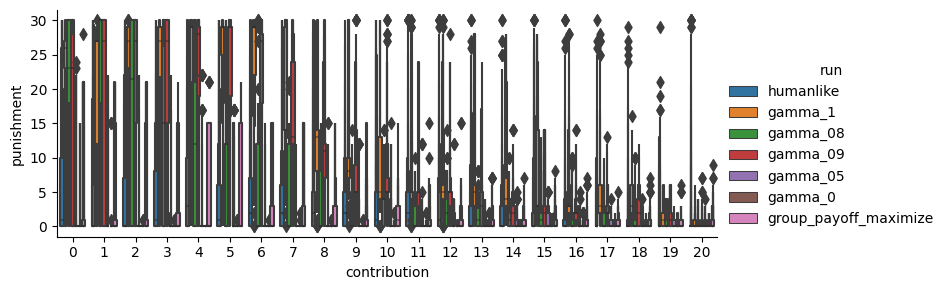

In [52]:
df["contribution"] = df["contribution"].astype(int)

w = ~df["run"].isin(
    [
        "pilot human manager",
        "pilot rule based manager",
    ]
)

dfs = df[w].copy()

g = sns.catplot(
    data=dfs,
    x="contribution",
    y="punishment",
    hue="run",
    kind="boxen",
    height=3,
    aspect=2.5,
)

g.savefig(os.path.join(fig_path, "comparison_pilot_policy_box.jpg"))

In [53]:
dfm = df.melt(
    id_vars=["episode", "round_number", "participant_code", "run"],
    value_vars=["punishment", "contribution", "common_good"],
)

# w = ((dfm['round_number'] == 0) & (dfm['variable'] == 'contribution'))

dfs = dfm.groupby(["run", "round_number", "variable"])["value"].mean().reset_index()

dfs = dfs.sort_values(["variable", "round_number", "run"])

dfs.to_csv(os.path.join(fig_path, "aggregates.csv"), index=False)